# 环境配置

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from tqdm import trange

# The multivariate Variance Gamma model basket option pricing and calibration 论文复刻

## table1

In [3]:
r = 0.03
rho = np.eye(3)
X_0 = np.array([100, 200, 300])
mu = np.array([-0.1368, -0.056, -0.1984])
sigma = np.array([0.1099, 0.1677, 0.0365])
weight = np.array([1/3, 1/6, 1/9]) # w是权重，omega才是参数

table1 = pd.DataFrame(data =  {'X_0': X_0, 'mu': mu,'sigma': sigma, 'weight' : weight},
                      index =  ['stock 1', 'stock 2', 'stock 3'])
table1

,X_0,mu,sigma,weight
stock 1,100,-0.1368,0.1099,0.333333
stock 2,200,-0.0560,0.1677,0.166667
stock 3,300,-0.1984,0.0365,0.111111


## table2

In [4]:
from scipy.stats import norm
import scipy.integrate as sci
import math
from scipy.stats import norm
from scipy.optimize import fsolve # 解决非线性方程组的数值求解问题
from scipy.optimize import bisect # 解决非线性方程组的数值求解问题
from scipy.stats import gamma # gamma分布的概率密度

### Approximate （上下限加权）

In [5]:
def C_approximate_calculate_func(T, v, K, sigma, mu, r, q):
    omega = 1/v * np.log(1 - 1/2 * (sigma ** 2) * v - mu * v)
    K_i = K / weight.copy() / len(omega)
    
    def f(x):    
        d_1_upper = (np.log(X_0/K_i) + (r - q + omega) * T + mu * x + sigma ** 2 * x)/(sigma * np.sqrt(x))
        d_2_upper = d_1_upper - sigma * np.sqrt(x)
        exp_upper = np.exp((r - q + omega ) * T + (mu + sigma ** 2 / 2) * x)
        X_price_upper = ((X_0 * exp_upper * norm.cdf(d_1_upper) - K_i * norm.cdf(d_2_upper)))
        S_upper = np.dot(X_price_upper, weight)
        
        lambda_i = weight * X_0 * np.exp((r - q + omega) * T + (mu + sigma ** 2 / 2) * x)
        sigma2Lambda = sum(sum(np.outer(lambda_i * sigma, lambda_i * sigma) * rho))
        # if sigma2Lambda == 0:
        #     r_i = np.sign(np.dot((lambda_i * sigma),rho))
        # else:
        r_i = np.dot((lambda_i * sigma),rho)/np.sqrt(sigma2Lambda)
        # r_i = r_i.clip(-1,1)
        # zero_indices = np.where(r_i == 0)[0]
        # r_i[zero_indices] = 0.1
        d_1_lower = (np.log(X_0/K_i) + (r - q + omega) * T + mu * x + sigma ** 2 * x / 2 * (1 + r_i ** 2))/(sigma * np.sqrt(x) * r_i)
        d_2_lower = d_1_lower - sigma * np.sqrt(x) * r_i
        exp_lower = np.exp((r + omega - q) * T + (mu + sigma ** 2 / 2) * x)
        X_price_lower = ((X_0 * exp_lower * norm.cdf(d_1_lower) - K_i * norm.cdf(d_2_lower)))
        S_lower = np.dot(X_price_lower, weight)

        var_upper_part1 = np.outer(X_0 * weight, X_0 * weight)
        var_upper_part2 = np.exp(2 * r * T)
        var_upper_part3 = np.outer(np.exp((weight - q) * T + mu * x + sigma ** 2 / 2 * x),np.exp((weight - q) * T + mu * x + sigma ** 2 / 2 * x))
        var_upper_part4 = np.exp(np.outer(sigma,sigma) * x) - 1
        var_upper = sum(sum(var_upper_part1 * var_upper_part2 * var_upper_part3 * var_upper_part4))

        var_lower_part1 = np.outer(X_0 * weight, X_0 * weight)
        var_lower_part2 = np.exp(2 * r * T)
        var_lower_part3 = np.outer(np.exp((weight - q) * T + mu * x + sigma ** 2 / 2 * x),np.exp((weight - q) * T + mu * x + sigma ** 2 / 2 * x))
        var_lower_part4 = np.exp(np.outer(sigma * r_i, sigma * r_i) * x) - 1
        var_lower = sum(sum(var_lower_part1 * var_lower_part2 * var_lower_part3 * var_lower_part4))

        var_part1 = np.outer(X_0 * weight, X_0 * weight)
        var_part2 = np.exp(2 * r * T)
        var_part3 = np.outer(np.exp((weight - q) * T + mu * x),np.exp((weight - q) * T + mu * x))
        var_part4_i_ne_j = np.exp((sigma ** 2 + (sigma ** 2).reshape(len(sigma),-1) + np.outer(sigma, sigma) * rho) * 2 * (1 - rho ** 2) * x/(4 - rho ** 2))
        np.fill_diagonal(var_part4_i_ne_j, np.outer(np.exp(x * sigma ** 2), np.exp(x * sigma ** 2))) # 生成E[XY]
        var_part4 = var_part4_i_ne_j - np.outer(np.exp(sigma ** 2 / 2 * x), np.exp(sigma ** 2 / 2 * x))
        var_Sy = sum(sum(var_part1 * var_part2 * var_part3 * var_part4))
        
        gamma_density = gamma(a=T/v, scale=v).pdf(x) # ((1/v) ** (T/v)) / (math.gamma(T/v)) * (x ** (T/v - 1)) * np.exp(-x / v)
        
        if var_upper - var_lower == 0:
            z_y = 0.5
        else:
            z_y = (var_upper - var_Sy)/(var_upper - var_lower)
        C_approximate = z_y * S_lower + (1 - z_y) * S_upper
        return C_approximate * gamma_density# , z_y
    # return sci.quad(f, 1e-10, np.inf)[0] * np.exp(-r * T)
    # return sci.quad(f, 0, np.inf)[0] * np.exp(-r * T)
    return sci.quad(f, 0, 100)[0] * np.exp(-r * T)
# C_approximate_calculate_func(T = 1, v = 0.5, K = 125, sigma = sigma, mu = mu, r = r, q = 0)

In [6]:
C_approximate_calculate_func(T = 1, v = 0.5, K = 125, sigma = sigma, mu = mu, r = r, q = 0)

0.14625400595771004

### sim（蒙特卡洛-向量化，指令并行）

In [79]:
from tqdm import tqdm
def monte_carlo_calculate_func(T, v, K, sigma, mu, r, q, power_num = 6):
    sim_times = 10 ** power_num
    np.random.seed(20240321) 
    Normal_values = multivariate_normal.rvs(mean=np.zeros(len(sigma)), cov=rho, size=sim_times)
    Gamma_values = np.random.gamma(shape = T/v, scale = v, size=sim_times)
    omega = 1/v * np.log(1 - 1/2 * (sigma ** 2) * v - mu * v)
    X_price_vector = X_0 * np.exp((r - q + omega) * T) * np.exp(np.outer(mu, Gamma_values)).T * np.exp(sigma * np.sqrt(Gamma_values.reshape(-1, 1)) * Normal_values)
    S_price_vector = np.dot(X_price_vector, weight)
    C_sim_vector_list = (S_price_vector - K) * (S_price_vector - K > 0)
    C_sim = sum(C_sim_vector_list) * np.exp(-r * T) / len(C_sim_vector_list) # 原论文是27.3230
    return C_sim

### 带入参数

In [8]:
# 表头
from itertools import product
# T, v, K, C_hat, C_sim, vare

T = [1, 2]
v = [0.5, 0.75, 0.9]
K = [75, 90, 100, 110, 125]

table2 = pd.DataFrame(list(product(T, v, K)), columns = ['T', 'v', 'K']).set_index(['T','v', 'K'])
table2.T

Empty DataFrame
Columns: [(1, 0.5, 75), (1, 0.5, 90), (1, 0.5, 100), (1, 0.5, 110), (1, 0.5, 125), (1, 0.75, 75), (1, 0.75, 90), (1, 0.75, 100), (1, 0.75, 110), (1, 0.75, 125), (1, 0.9, 75), (1, 0.9, 90), (1, 0.9, 100), (1, 0.9, 110), (1, 0.9, 125), (2, 0.5, 75), (2, 0.5, 90), (2, 0.5, 100), (2, 0.5, 110), (2, 0.5, 125), (2, 0.75, 75), (2, 0.75, 90), (2, 0.75, 100), (2, 0.75, 110), (2, 0.75, 125), (2, 0.9, 75), (2, 0.9, 90), (2, 0.9, 100), (2, 0.9, 110), (2, 0.9, 125)]
Index: []

[0 rows x 30 columns]

In [9]:
r = 0.03
rho = np.eye(3)
X_0 = np.array([100, 200, 300])
q = np.array([0, 0, 0])
mu = np.array([-0.1368, -0.056, -0.1984])
sigma = np.array([0.1099, 0.1677, 0.0365])
weight = np.array([1/3, 1/6, 1/9]) # w是权重，omega才是参数

In [10]:
from tqdm import tqdm
C_sim_result_list = list()
C_approximate_list = list()
power_num = 6

for (T,v,K) in tqdm(table2.index.values):
    C_approximate = C_approximate_calculate_func(T, v, K, sigma, mu, r, q)
    C_approximate_list.append(C_approximate)
    
    C_sim = monte_carlo_calculate_func(T, v, K, sigma, mu, r, q, power_num)
    C_sim_result_list.append(C_sim)

100%|██████████| 30/30 [00:21<00:00,  1.37it/s]


In [11]:
table2.loc[:,'$\overline{C}[K]$'] = C_approximate_list
table2.loc[:,'$C^sim[K]$'] = C_sim_result_list
table2.loc[:,r'$\varepsilon[K]$'] = abs(table2.loc[:,'$\overline{C}[K]$'] - table2.loc[:,'$C^sim[K]$'])/ C_sim_result_list
table2 = table2.round(4)
table2.to_clipboard()
table2

$\overline{C}[K]$  $C^sim[K]$  $\varepsilon[K]$
T v    K                                                   
1 0.50 75             27.3753     27.3116            0.0023
       90             13.8407     13.5774            0.0194
       100             6.4589      5.9578            0.0841
       110             1.8062      1.2027            0.5017
       125             0.1463      0.0060           23.2586
  0.75 75             27.5484     27.4386            0.0040
       90             14.2749     13.9589            0.0226
       100             6.9481      6.4220            0.0819
       110             2.0770      1.3957            0.4882
       125             0.1465      0.0051           27.6318
  0.90 75             27.6603     27.5319            0.0047
       90             14.5006     14.1706            0.0233
       100             7.1814      6.6586            0.0785
       110             2.2016      1.4925            0.4751
       125             0.1465      0.0048           29.2339
2 0.50 75             29.7271     29.6091            0.0040
       90             17.0824     16.6890            0.0236
       100            10.1489      9.4982            0.0685
       110             5.0638      4.2383            0.1948
       125             1.1728      0.5537            1.1180
  0.75 75             30.0306     29.8354            0.0065
       90             17.7131     17.2421            0.0273
       100            10.9011     10.1977            0.0690
       110             5.7414      4.8520            0.1833
       125             1.4677      0.7026            1.0890
  0.90 75             30.2182     29.9823            0.0079
       90             18.0446     17.5383            0.0289
       100            11.2731     10.5484            0.0687
       110             6.0684      5.1560            0.1770
       125             1.6200      0.7811            1.0739

## figure 1

### 试试逼近

#### 函数定义

In [12]:
import sys
sys.path.append('./Users/zyz/Library/CloudStorage/OneDrive-uibe.edu.cn/Code/Python/mypackage')
from mypackage.my_plot import my_plot

In [13]:
def second_derivative_approx_calculation_func(T, v, K, sigma, mu, r, q, h, cal_func):
    K_plus_h = K + h
    K_minus_h = K - h
    C_sim_at_K_plus_h = cal_func(T, v, K_plus_h, sigma, mu, r, q)
    C_sim_at_K_minus_h = cal_func(T, v, K_minus_h, sigma, mu, r, q)
    C_sim_at_K = cal_func(T, v, K, sigma, mu, r, q)

    second_derivative_approx = (C_sim_at_K_plus_h - 2*C_sim_at_K + C_sim_at_K_minus_h) / (h ** 2)
    return second_derivative_approx

#### figure的函数

In [14]:
def figure_calculate_func(T, v, K, sigma, mu, r, q, approx_num = 200, h_times = 2, plot_name = ['sigma1 = 0.1', '1-1']):
    second_derivative_approx_list1 = list()
    second_derivative_approx_list2 = list()
    sigma[0] = 0.1
    h = (np.linspace(50,130,approx_num)[1] - np.linspace(50,130,approx_num)[0]) * h_times

    for K in tqdm(np.linspace(50,130,approx_num)):
        second_derivative_approx1 = second_derivative_approx_calculation_func(T, v, K, sigma, mu, r, q, h, C_approximate_calculate_func)
        second_derivative_approx2 = second_derivative_approx_calculation_func(T, v, K, sigma, mu, r, q, h, monte_carlo_calculate_func)
        second_derivative_approx_list1.append(second_derivative_approx1)
        second_derivative_approx_list2.append(second_derivative_approx2)
    plot_df = pd.DataFrame(index = np.linspace(50,130,approx_num))
    plot_df['Approximate density'] = second_derivative_approx_list1
    plot_df['Empirical density'] = second_derivative_approx_list2
    my_plot(plot_df, [f'Probability distribution function {plot_name[0]}', 'Basket terminal value', '', f'figure{plot_name[1]}']).line_plot()
    return plot_df

#### 模拟

approx_num最好大于40  
h_times如果太小就容易有很大波动  
h_times理论上和approx_num一起加  

In [ ]:
T, v, sigma, mu, power_num = 1, 0.7514, np.array([0.1099, 0.1677, 0.0365]), np.array([-0.1368, -0.056, -0.1984]), 6
approx_num, h_times = 60, 1

100%|██████████| 2/2 [00:00<00:00, 2237.56it/s]


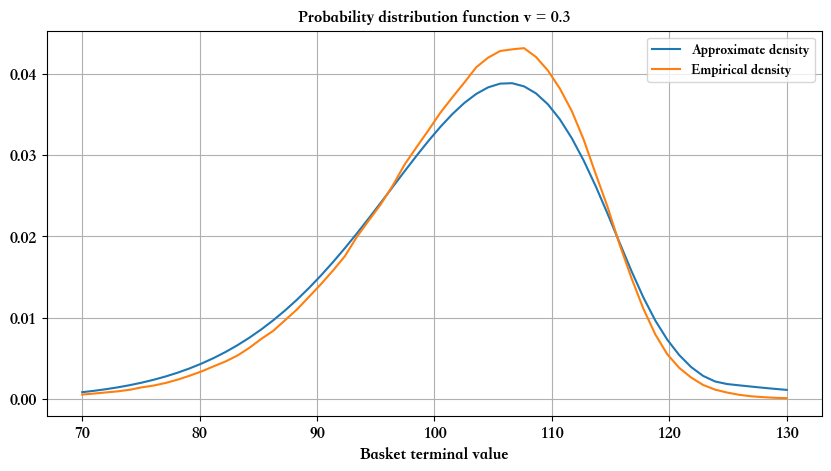

In [ ]:
v = 0.3
plot_df = figure_calculate_func(T, v, K, sigma, mu, r, q, approx_num, h_times,
                                plot_name = ['v = 0.3', '1-1'])

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 2049.00it/s]


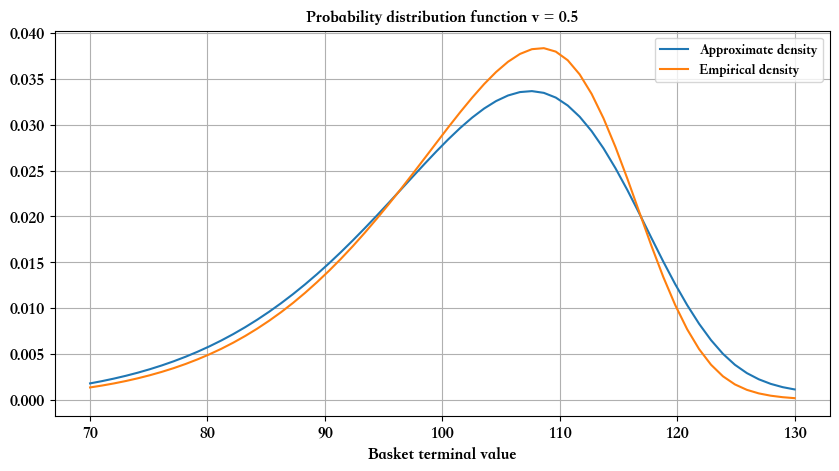

In [ ]:
v = 0.5
plot_df = figure_calculate_func(T, v, K, sigma, mu, r, q, approx_num, h_times,
                                plot_name = ['v = 0.5', '1-2'])

100%|██████████| 2/2 [00:00<00:00, 2197.70it/s]


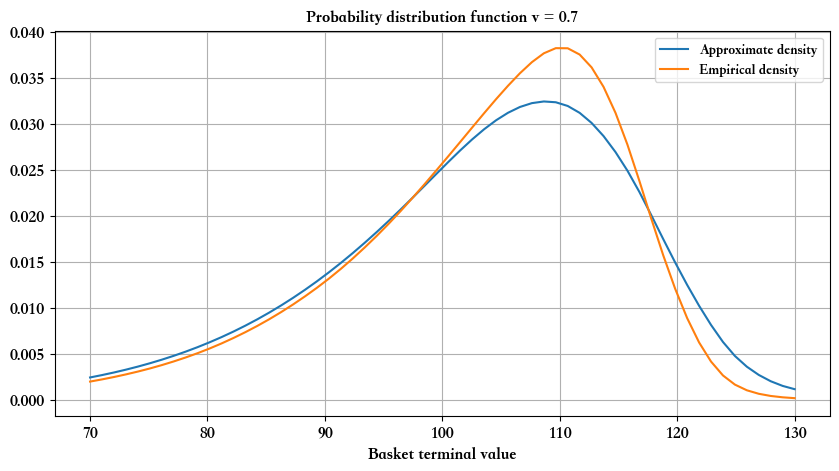

In [ ]:
v = 0.7
plot_df = figure_calculate_func(T, v, K, sigma, mu, r, q, approx_num, h_times,
                                plot_name = ['v = 0.7', '1-3'])

100%|██████████| 2/2 [00:00<00:00, 2241.74it/s]


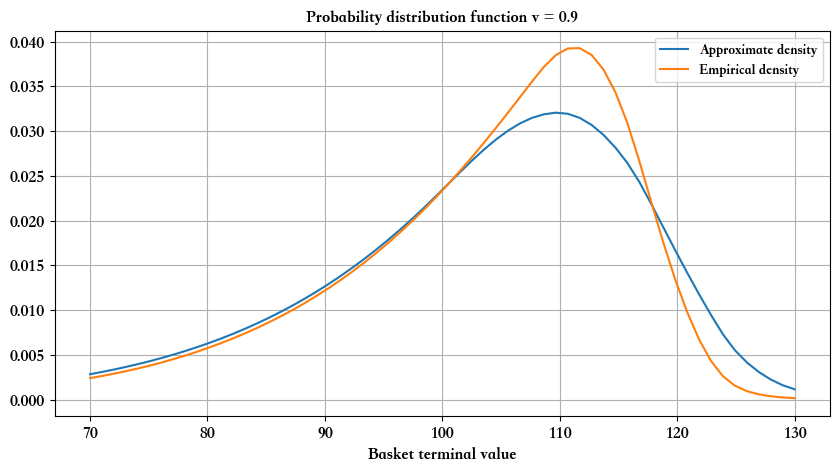

In [ ]:
v = 0.9
plot_df = figure_calculate_func(T, v, K, sigma, mu, r, q, approx_num, h_times,
                                plot_name = ['v = 0.9', '1-4'])

## Figure 3

Relative error for different choices of sigma 1

In [ ]:
r = 0.03
rho = np.eye(3)
X_0 = np.array([100, 200, 300])
q = np.array([0, 0, 0])
mu = np.array([-0.1368, -0.056, -0.1984])
sigma = np.array([0.1099, 0.1677, 0.0365])
weight = np.array([1/3, 1/6, 1/9]) # w是权重，omega才是参数
power_num = 6
v = 0.05
T = 1
K = 100

In [ ]:
from tqdm import tqdm
varepsilon_list = list()
C_sim_result_list = list()
C_approximate_list = list()
sim_times = 100
for sigma_1 in tqdm(np.linspace(0.1,1,sim_times)):
    sigma[0] = sigma_1
    C_approximate = C_approximate_calculate_func(T, v, K, sigma, mu, r, q)
    C_approximate_list.append(C_approximate)
    
    C_sim = monte_carlo_calculate_func(T, v, K, sigma, mu, r, q, power_num)
    C_sim_result_list.append(C_sim)
    
    varepsilon = abs(C_approximate - C_sim)/ C_sim
    varepsilon_list.append(varepsilon)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


100%|██████████| 1/1 [00:00<00:00, 1240.92it/s]

,varepsilon
0.000000,0.038714
0.111111,0.194065
0.222222,0.328939
0.333333,0.416907
0.444444,0.471797
0.555556,0.505538
0.666667,0.525439
0.777778,0.535714
0.888889,0.538653
1.000000,0.535228


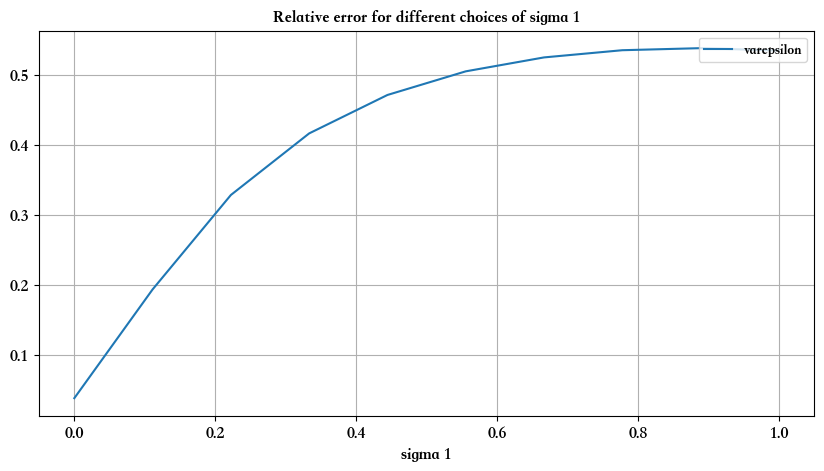

In [ ]:
plot_df_varepsilon = pd.DataFrame(index = np.linspace(0,1,sim_times))
plot_df_varepsilon['varepsilon'] = varepsilon_list
my_plot(plot_df_varepsilon, [f'Relative error for different choices of sigma 1', 'sigma 1', '', f'figure 3']).line_plot()
plot_df_varepsilon

## table 3

### 带入参数

In [ ]:
v = 0.7514
r = 0.03
rho = np.eye(3)
X_0 = np.array([100, 200, 300])
q = np.array([0, 0, 0])
mu = np.array([-0.1368, -0.056, -0.1984])
sigma = np.array([0.1099, 0.1677, 0.0365])
weight = np.array([1/3, 1/6, 1/9]) # w是权重，omega才是参数

In [ ]:
# 表头
from itertools import product
# T, v, K, C_hat, C_sim, vare

T = [1, 2]
sigma_1 = [0.05, 0.25, 0.75]
K = [75, 90, 100, 110, 125]

table3 = pd.DataFrame(list(product(T, sigma_1, K)), columns = ['T', 'sigma_1', 'K']).set_index(['T','sigma_1', 'K'])
table3.T

Empty DataFrame
Columns: [(1, 0.05, 75), (1, 0.05, 90), (1, 0.05, 100), (1, 0.05, 110), (1, 0.05, 125), (1, 0.25, 75), (1, 0.25, 90), (1, 0.25, 100), (1, 0.25, 110), (1, 0.25, 125), (1, 0.75, 75), (1, 0.75, 90), (1, 0.75, 100), (1, 0.75, 110), (1, 0.75, 125), (2, 0.05, 75), (2, 0.05, 90), (2, 0.05, 100), (2, 0.05, 110), (2, 0.05, 125), (2, 0.25, 75), (2, 0.25, 90), (2, 0.25, 100), (2, 0.25, 110), (2, 0.25, 125), (2, 0.75, 75), (2, 0.75, 90), (2, 0.75, 100), (2, 0.75, 110), (2, 0.75, 125)]
Index: []

[0 rows x 30 columns]

In [ ]:
from tqdm import tqdm
C_sim_result_list = list()
C_approximate_list = list()
power_num = 6

for (T,sigma_1,K) in tqdm(table3.index.values):
    sigma[0] = sigma_1
    # print(T, sigma_1, K)
    C_approximate = C_approximate_calculate_func(T, v, K, sigma, mu, r, q)
    C_approximate_list.append(C_approximate)
    
    C_sim = monte_carlo_calculate_func(T, v, K, sigma, mu, r, q, power_num)
    C_sim_result_list.append(C_sim)

100%|██████████| 30/30 [00:24<00:00,  1.20it/s]


In [ ]:
table3.loc[:,'$\overline{C}[K]$'] = C_approximate_list
table3.loc[:,'$C^sim[K]$'] = C_sim_result_list
table3.loc[:,r'$\varepsilon[K]$'] = abs(table3.loc[:,'$\overline{C}[K]$'] - table3.loc[:,'$C^sim[K]$'])/ C_sim_result_list
table3 = table3.round(4)
table3.to_clipboard()
table3

$\overline{C}[K]$  $C^sim[K]$  $\varepsilon[K]$
T sigma_1 K                                                   
1 0.05    75             27.5539     27.4120            0.0052
          90             14.2784     13.8910            0.0279
          100             6.9455      6.3187            0.0992
          110             2.0850      1.2940            0.6113
          125             0.2267      0.0025           90.9037
  0.25    75             28.0679     27.5413            0.0191
          90             15.4312     14.3012            0.0790
          100             8.5238      6.9839            0.2205
          110             3.7582      2.0269            0.8542
          125             0.9779      0.1130            7.6547
  0.75    75             32.1258     28.2643            0.1366
          90             22.0174     16.6545            0.3220
          100            17.1392     11.0177            0.5556
          110            12.6874      7.4800            0.6962
          125             8.4193      4.8678            0.7296
2 0.05    75             30.0506     29.7944            0.0086
          90             17.7401     17.1358            0.0353
          100            10.9244     10.0451            0.0875
          110             5.7633      4.6827            0.2307
          125             1.5470      0.6021            1.5694
  0.25    75             30.9403     30.0484            0.0297
          90             19.3718     17.7785            0.0896
          100            12.9830     10.9853            0.1819
          110             8.0337      5.7972            0.3858
          125             3.4986      1.4419            1.4264
  0.75    75             37.4744     31.3860            0.1940
          90             28.5243     21.2675            0.3412
          100            23.9093     16.3827            0.4594
          110            19.9829     12.9346            0.5449
          125            14.8826      9.7102            0.5327

## Figure 2

In [91]:
T, v, sigma, mu, power_num = 1, 0.7514, np.array([0.1099, 0.1677, 0.0365]), np.array([-0.1368, -0.056, -0.1984]), 6
approx_num, h_times = 60, 3

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 1504.95it/s]


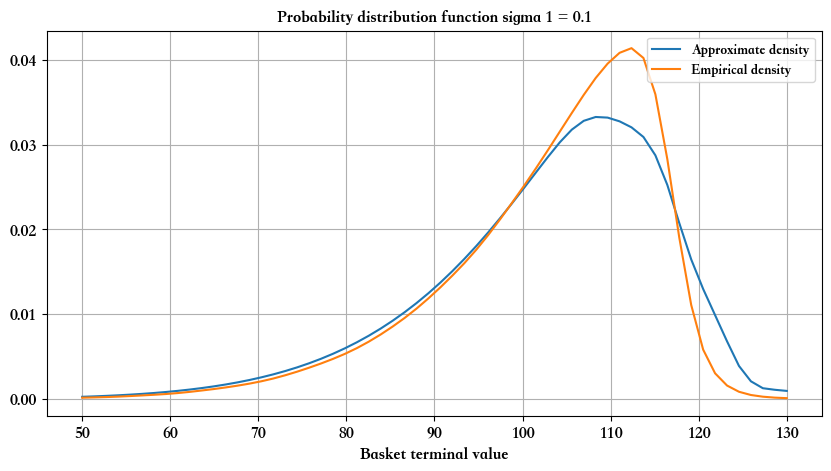

In [92]:
sigma[0] = 0.1
plot_df = figure_calculate_func(T, v, K, sigma, mu, r, q, approx_num, h_times,
                                plot_name = ['sigma 1 = 0.1', '2-1'])

100%|██████████| 2/2 [00:00<00:00, 1926.64it/s]


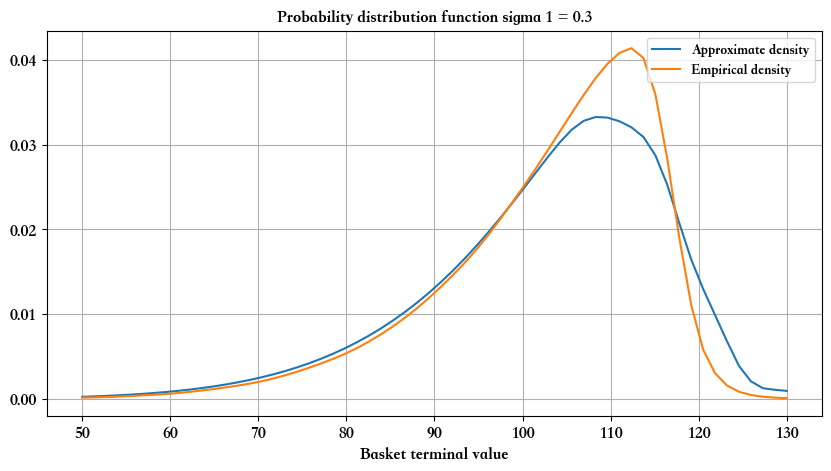

In [93]:
sigma[0] = 0.3
plot_df = figure_calculate_func(T, v, K, sigma, mu, r, q, approx_num, h_times,
                                plot_name = ['sigma 1 = 0.3', '2-2'])

100%|██████████| 2/2 [00:00<00:00, 2132.34it/s]


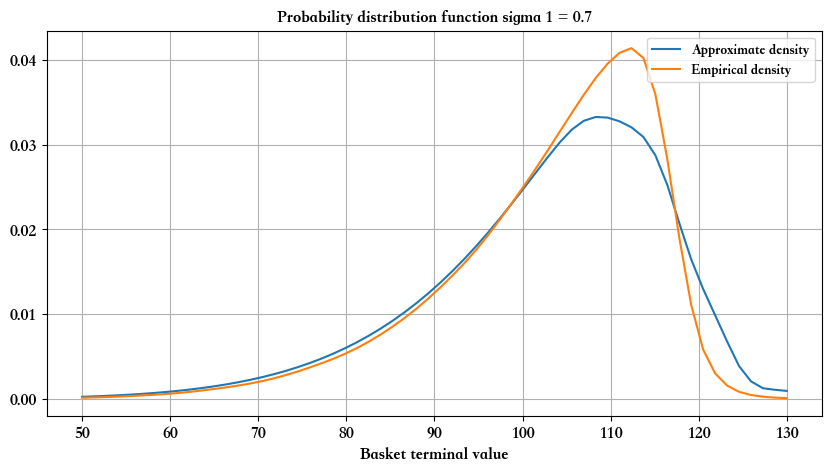

In [94]:
sigma[0] = 0.7
plot_df = figure_calculate_func(T, v, K, sigma, mu, r, q, approx_num, h_times,
                                plot_name = ['sigma 1 = 0.7', '2-3'])

100%|██████████| 2/2 [00:00<00:00, 1839.61it/s]


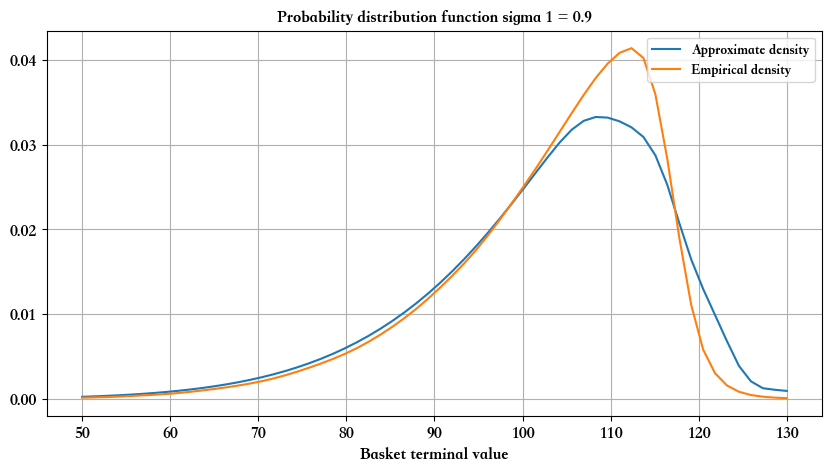

In [95]:
sigma[0] = 0.9
plot_df = figure_calculate_func(T, v, K, sigma, mu, r, q, approx_num, h_times,
                                plot_name = ['sigma 1 = 0.9', '2-4'])

# Table 8-10 & Figure 6-7

## Table 8

In [15]:
table8_data = np.array(["Alcoa Incorporated" , 36.26 , 0.5374 , -0.5072 , 0.61 , "American Express Company" , 45.53 , 0.3715 , -1.1845 , 1.99 , "American International group" , 48.23 , 0.4076 , -1.8592 , 4.69 , "Bank of America" , 38.56 , 0.4256 , -1.3081 , 2.63 , "Boeing Corporation" , 78.66 , 0.364 , -0.6805 , 3.7 , "Caterpillar" , 85.28 , 0.3731 , -0.7144 , 2.81 , "JP Morgan" , 45.76 , 0.349 , -0.6409 , 4.65 , "Chevron" , 93.18 , 0.2168 , -0.4838 , 1.53 , "Citigroup" , 25.11 , 0.4227 , -0.6585 , 6.17 , "Coca Cola Company" , 60.11 , 0.271 , -0.5272 , 6.55 , "Walt Disney Company" , 31.33 , 0.2962 , -0.5588 , 2.26 , "DuPont" , 52.02 , 0.3222 , -0.5008 , 1.14 , "Exxon Mobile" , 94 , 0.2646 , -0.597 , 8.08 , "General Electric" , 32.69 , 0.2327 , -0.2801 , 4.18 , "General Motors" , 20.13 , 0.6881 , -1.3389 , 4.01 , "Hewlet-Packard" , 48.18 , 0.3927 , -0.6216 , 1.01 , "Home Depot" , 28.68 , 0.4451 , -1.0861 , 0.5 , "Intel" , 22.55 , 0.3652 , -0.7617 , 1.82 , "IBM" , 124.4 , 0.2461 , -0.609 , 6.43 , "Johnson & Johnson" , 66.51 , 0.1775 , -0.2969 , 2.86 , "McDonald's" , 58.3 , 0.2122 , -0.4376 , 1.79 , "Merck & Company" , 39.76 , 0.416 , -0.9171 , 8.62 , "Microsoft" , 30 , 0.3407 , -0.6717 , 1.59 , "3M" , 82.9 , 0.2608 , -0.4586 , 1.12 , "Pfizer" , 20.47 , 0.2156 , 0.3303 , 2.84 , "Practer & Gamble" , 67.17 , 0.1916 , -0.4434 , 1.55 , "AT&T" , 37.51 , 0.3172 , -0.7123 , 0.72 , "United Technologies" , 72.51 , 0.3082 , -0.6888 , 3.06 , "Verizon" , 36.03 , 0.3141 , -0.6515 , 1.04 , "Wal-Mart Stores" , 56.31 , 0.2112 , -0.3738 , 1.17 ])

In [45]:
table8 = pd.DataFrame(data = table8_data.reshape(30,-1)).set_index(0)
table8.columns = ['X_0', 'sigma_i', 'mu_i', 'RMSE']
table8.index.name = ""
table8 = table8.astype(float)
table8

,X_0,sigma_i,mu_i,RMSE
,,,,
Alcoa Incorporated,36.26,0.5374,-0.5072,0.61
American Express Company,45.53,0.3715,-1.1845,1.99
American International group,48.23,0.4076,-1.8592,4.69
Bank of America,38.56,0.4256,-1.3081,2.63
Boeing Corporation,78.66,0.3640,-0.6805,3.70
Caterpillar,85.28,0.3731,-0.7144,2.81
JP Morgan,45.76,0.3490,-0.6409,4.65
Chevron,93.18,0.2168,-0.4838,1.53
Citigroup,25.11,0.4227,-0.6585,6.17


## Table 9 

In [46]:
table9_data = np.array(["Day" , " 18 April 2008 " , " 22 May 2008 " , " 18 July 2008" , "Time to maturity" , " 64 days" , " 30 days" , " 29 days" , "v" , 0.076312 , 0.0438 , 0.03395 , "rho" , 0.064745 , 0.23293 , 0.21057 , "RMSE" , 0.0796 , 0.1311 , 0.0367 , "Relative error" , 0.0154 , 0.0574 , 0.0401])

In [53]:
table9 = pd.DataFrame(table9_data.reshape(6,-1))
table9.columns = table9.iloc[0]
table9.columns.name = table9.iloc[0,0]
table9 = table9.drop(table9.index[0])
table9.index = table9.iloc[:,0]
table9 = table9.drop(table9.columns[0], axis=1)
table9.index.name = ''
table9.iloc[1:,:] = table9.iloc[1:,:].astype(float)
table9

Day,18 April 2008,22 May 2008,18 July 2008
,,,
Time to maturity,64 days,30 days,29 days
v,0.076312,0.0438,0.03395
rho,0.064745,0.23293,0.21057
RMSE,0.0796,0.1311,0.0367
Relative error,0.0154,0.0574,0.0401


## Table 10

In [54]:
table10_data = np.array(["Strikes" , "Market prices" , "Model price" , 97 , 31.50 , 31.40  , 99 , 29.50 , 29.43  , 100 , 28.55 , 28.44  , 101 , 27.55 , 27.46  , 102 , 26.58 , 26.48  , 103 , 25.60 , 25.50  , 104 , 24.63 , 24.52  , 105 , 23.65 , 23.55  , 106 , 22.70 , 22.58  , 107 , 21.73 , 21.62  , 108 , 20.78 , 20.66  , 109 , 19.83 , 19.70  , 110 , 18.85 , 18.76  , 111 , 17.95 , 17.82  , 112 , 17.00 , 16.88  , 113 , 16.05 , 15.96  , 114 , 15.15 , 15.04  , 115 , 14.25 , 14.14  , 116 , 13.33 , 13.25  , 117 , 12.50 , 12.38  , 118 , 11.58 , 11.52  , 119 , 10.73 , 10.67  , 120 , 9.93 , 9.85  , 121 , 9.13 , 9.04  , 122 , 8.33 , 8.26  , 123 , 7.55 , 7.50  , 124 , 6.80 , 6.77  , 125 , 6.10 , 6.07  , 126 , 5.40 , 5.40  , 127 , 4.75 , 4.76  , 128 , 4.13 , 4.16  , 129 , 3.55 , 3.59  , 130 , 3.02 , 3.07  , 131 , 2.53 , 2.58  , 132 , 2.08 , 2.14  , 133 , 1.68 , 1.74  , 134 , 1.33 , 1.38  , 135 , 1.04 , 1.08  , 136 , 0.78 , 0.81  , 137 , 0.59 , 0.59  , 138 , 0.42 , 0.41  , 139 , 0.30 , 0.27  , 140 , 0.20 , 0.17])

In [55]:
table10 = pd.DataFrame(table10_data.reshape(44,-1))
table10.columns = table10.iloc[0]
table10 = table10.drop(table10.index[0])
table10.index = table10.iloc[:,0]
table10 = table10.drop(table10.columns[0], axis=1)
table10 = table10.astype(float)
table10.T

Strikes,97,99,100,101,102,103,104,105,106,107,...,131,132,133,134,135,136,137,138,139,140
0,,,,,,,,,,,,,,,,,,,,,
Market prices,31.5,29.50,28.55,27.55,26.58,25.6,24.63,23.65,22.70,21.73,...,2.53,2.08,1.68,1.33,1.04,0.78,0.59,0.42,0.30,0.20
Model price,31.4,29.43,28.44,27.46,26.48,25.5,24.52,23.55,22.58,21.62,...,2.58,2.14,1.74,1.38,1.08,0.81,0.59,0.41,0.27,0.17


## Table 11

In [56]:
"The market and model prices for a Dow Jones call option on 18 April 2008 and time to maturity equal to 64 days."

'The market and model prices for a Dow Jones call option on 18 April 2008 and time to maturity equal to 64 days.'

In [104]:
T = 64/365
v = 0.076312
rho_i = 0.064745
rho = np.ones(30 * 30).reshape(30,30) * rho_i
np.fill_diagonal(rho, 1)
X_0 = np.array(table8.loc[:,'X_0'])
sigma = np.array(table8.loc[:,'sigma_i'])
mu = np.array(table8.loc[:,'mu_i'])

In [105]:
# TODO: weight有问题，应该是价格加权
weight = X_0/X_0.sum()
weight

array([0.02297656, 0.0288506 , 0.03056149, 0.02443398, 0.0498438 ,
       0.05403864, 0.02899634, 0.05904457, 0.01591124, 0.03808938,
       0.01985261, 0.03296306, 0.05956417, 0.02071439, 0.0127556 ,
       0.0305298 , 0.01817341, 0.01428906, 0.07882747, 0.04214482,
       0.03694246, 0.02519438, 0.01900984, 0.05253053, 0.01297105,
       0.04256303, 0.02376864, 0.04594679, 0.02283082, 0.03568147])

In [119]:
model_price_list = list()
model_price_list.append(C_approximate_calculate_func(T = T, v = v, K = 97, sigma = sigma, mu = mu, r = r, q = 0))
for K_k in tqdm(np.arange(99,141)):
    model_price_list.append(C_approximate_calculate_func(T = T, v = v, K = K_k, sigma = sigma, mu = mu, r = r, q = 0))

100%|██████████| 42/42 [00:21<00:00,  1.98it/s]


In [123]:
table10_replicate = table10.copy()
table10_replicate.loc[:,'复刻结果'] = model_price_list
table10_replicate.round(2).to_clipboard()
table10_replicate

,Market prices,Model price,复刻结果
Strikes,,,
97,31.50,31.40,14.708568
99,29.50,29.43,14.271592
100,28.55,28.44,14.055619
101,27.55,27.46,13.841462
102,26.58,26.48,13.629227
103,25.60,25.50,13.419023
104,24.63,24.52,13.210950
105,23.65,23.55,13.005099
106,22.70,22.58,12.801542
